In [8]:
path = "/gwdata/users/lzhang/public/cmstestbeam/2023_03_cmstiming_BTL/TOFHIR/RecoData/"

### Root file name

In [9]:
run = 67962
root_suffix = '.root'
reco_file_name = f'run{str(run)}_e'+root_suffix
reco_file = path + reco_file_name

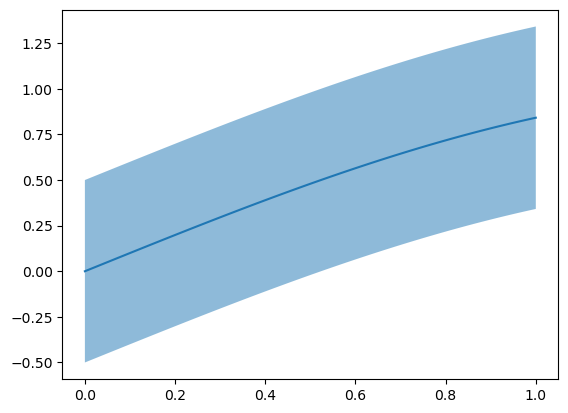

In [73]:
reco_files = []
for run in range(67962,67967): # 62 have problem with channel 3!!!???
    reco_file_name = f'run{str(run)}_e'+root_suffix
    reco_files.append(path + reco_file_name)

### channel mapping

In [10]:
channel_map_ref = {}

In [11]:
for ibar in range(0,16):
    if ibar <= 7: icL = 14 - 2 * ibar
    else: icL = 1 + 2 * (ibar - 8)
    icR = 31 - icL
    channel_map_ref[str(ibar)] = [icL, icR]

In [12]:
channel_map_test = {}

In [13]:
for ibar in range(0,16):
    channel_map_test[str(ibar)] = [channel_map_ref[str(ibar)][0]+64, channel_map_ref[str(ibar)][1]+64]

### Flow with uproot

In [14]:
import uproot as u
import numpy as np

In [15]:
tin = u.open(reco_file, num_workers=4)['data']

In [16]:
analyzer = tin.arrays(["energy", "channelIdx"], library="np")

In [86]:
# tin = u.open(reco_files, num_workers=4)['data']

# import pandas as pd
# with u.open(reco_file) as fin:
#     fin['data'].show()
    # analyzer = tin.arrays(["energy"], library="pd")
    # print(analyzer.head(10))

### Plotting functions

In [17]:
import matplotlib.pyplot as plt
import boost_histogram as bh
import mplhep as hep
from matplotlib.ticker import AutoMinorLocator
plt.style.use(hep.style.ROOT)
import matplotlib
matplotlib.use('Agg') # Use a non-interactive backend that does not show plots on the screen

from scipy.optimize import curve_fit

In [18]:
def save_plot_batch( plot_str ):
    plt.savefig(plot_str)
    plt.show()
    plt.close()

In [12]:
# import ROOT

# def landau(x, mu, sigma):
#     return ROOT.TMath.Landau(x, mpv = mu, sigma = sigma, norm = ROOT.kFALSE)

Welcome to JupyROOT 6.26/10


In [15]:
# def landau(x, A, mu, sigma):
#     if (x - mu) / sigma < -5.: return 0.
#     return A * np.exp(- (x - mu) / sigma) * np.sinh((x - mu) / sigma)

In [19]:
import ROOT as R

Welcome to JupyROOT 6.26/10


In [20]:
def selfit_landau(th, low_edge, high_edge, maximum):
    landau = R.TF1("fit","landau",low_edge,high_edge)
    landau.SetParLimits(1,maximum-30,maximum+30)
    th.Fit("fit","Q0")
    par = landau.GetParameters()
    par_err = landau.GetParErrors()
    return par[0], par[1], par[2], par_err[0], par_err[1], par_err[2]

In [21]:
def landau_eval(x, amp, mpv, sigma):
    landau = R.TF1("fit",f"{str(amp)}*TMath::Landau(x,{str(mpv)},{str(sigma)})",-200,2200)
    return landau.Eval(x)

### Sum_energy_ref_67962~67966

In [29]:
# # EL + ER (reference module)
# sum_energy_list_ref = []
# for key, vals in channel_map_ref.items():
#     energy_list = []
#     for _evt in range(len(analyzer['channelIdx'])):
#         if (analyzer['channelIdx'][_evt][vals[0]]>=0):
#             if key == "9":
#                 energy_list.append(0.)
#             else:
#                 energy_list.append(analyzer['energy'][_evt][analyzer['channelIdx'][_evt][vals[0]]])
#         if (analyzer['channelIdx'][_evt][vals[1]]>=0):
#             energy_list.append(analyzer['energy'][_evt][analyzer['channelIdx'][_evt][vals[1]]])
#     sum_energy_list_ref.append(np.sum(np.array(energy_list)))

5617407.0
3116647.5
3492265.8
3357013.5
10281191.0
15702722.0
20729362.0
35881324.0
27690174.0
2567123.3951330185
7544823.0
3185938.2
2014121.1
4448972.0
3104750.0
3013544.8


In [224]:
from multiprocessing import Pool

# define a function to be called by each process
def process_ref(key_vals):
    key, vals = key_vals
    energy_list = []
    for _evt in range(len(analyzer['channelIdx'])):
        if (analyzer['channelIdx'][_evt][vals[0]]>=0):
            if key == "9":
                energy_list.append(0.)
                # energy_list.append(analyzer['energy'][_evt][analyzer['channelIdx'][_evt][vals[0]]])
            else:
                energy_list.append(analyzer['energy'][_evt][analyzer['channelIdx'][_evt][vals[0]]])
        if (analyzer['channelIdx'][_evt][vals[1]]>=0):
            energy_list.append(analyzer['energy'][_evt][analyzer['channelIdx'][_evt][vals[1]]])
    return np.sum(np.array(energy_list))/len(energy_list)

# create a list of key-value pairs
key_vals_list = [(key, vals) for key, vals in channel_map_ref.items()]

# create a Pool with 16 worker processes
with Pool(16) as p:
    # call process_ref for each key-value pair in key_vals_list
    sum_energy_list_ref = p.map(process_ref, key_vals_list)

sum_energy_arr_ref = np.array(sum_energy_list_ref)


In [225]:
len(sum_energy_arr_ref)
sum_energy_arr_ref

array([430.1658974 , 289.06596906, 207.92704427, 247.17253542,
       392.33515882, 578.09289631, 242.59308482, 216.40124482,
       401.42408108, 807.54027191, 503.92928229, 463.79621451,
       347.03860501, 261.52056634, 216.0904195 , 395.469362  ])

In [226]:
num_bins = 16
bin_edges = np.arange(num_bins+1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

fig, ax = plt.subplots()
hist, _, _ = ax.hist(np.arange(num_bins), 
                     bins=bin_edges, 
                     weights=sum_energy_arr_ref, 
                     alpha=0.6, 
                     edgecolor='black', 
                     color = '#958CDD',
                     log=False)

ax.set_xticks(bin_centers)
ax.set_xticklabels(np.arange(num_bins))
ax.set_xlabel(f"Bar Number [reference mudule] run {str(run)}")
ax.set_ylabel("Sum of energy [L+R]")

save_plot_batch(f'Sum_energy_ref_{str(run)}.png')

### Sum_energy_test_67962~67966

In [197]:
from multiprocessing import Pool

# define a function to be called by each process
def process_test(key_vals):
    key, vals = key_vals
    energy_list = []
    for _evt in range(len(analyzer['channelIdx'])):
        if (analyzer['channelIdx'][_evt][vals[0]]>=0):
            if key == "9":
                # energy_list.append(0.)
                energy_list.append(analyzer['energy'][_evt][analyzer['channelIdx'][_evt][vals[0]]])
            else:
                energy_list.append(analyzer['energy'][_evt][analyzer['channelIdx'][_evt][vals[0]]])
        if (analyzer['channelIdx'][_evt][vals[1]]>=0):
            energy_list.append(analyzer['energy'][_evt][analyzer['channelIdx'][_evt][vals[1]]])
    return np.sum(np.array(energy_list))/len(energy_list)

# create a list of key-value pairs
key_vals_list = [(key, vals) for key, vals in channel_map_test.items()]

# create a Pool with 16 worker processes
with Pool(16) as p:
    # call process_ref for each key-value pair in key_vals_list
    sum_energy_list_test = p.map(process_test, key_vals_list)

sum_energy_arr_test = np.array(sum_energy_list_test)


In [198]:
len(sum_energy_arr_test)
sum_energy_arr_test

array([ 72.10473937,  22.67222645,  35.46444804,  79.59935702,
       102.50320629, 109.67919994,  23.11657705, 128.14948294,
       112.77943922,  71.79691651,  52.71517551,  51.82012783,
        76.80583872,  83.19656024,  24.35508856,  43.33404872])

In [199]:
num_bins = 16
bin_edges = np.arange(num_bins+1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

fig, ax = plt.subplots()
hist, _, _ = ax.hist(np.arange(num_bins), 
                     bins=bin_edges, 
                     weights=sum_energy_arr_test, 
                     alpha=0.6, 
                     edgecolor='black', 
                     color = '#958CDD',
                     log=False)

ax.set_xticks(bin_centers)
ax.set_xticklabels(np.arange(num_bins))
ax.set_xlabel(f"Bar Number [test mudule] run {str(run)}")
ax.set_ylabel("Sum of energy [L+R]")

save_plot_batch(f'Sum_energy_test_{str(run)}.png')

### energy_spectrum_test_67962~67966(center3)

In [39]:
from multiprocessing import Pool
from tqdm import tqdm

# define a function to be called by each process
def process_test(key_vals):
    key, vals = key_vals
    energy_list = [[]]*3
    energy_list[0] = [] # on the 'left'
    energy_list[1] = [] # on the 'right'
    energy_list[2] = [] # on the 'combined'
    
    for _evt in range(len(analyzer['channelIdx'])):
        if (analyzer['channelIdx'][_evt][vals[0]]>=0):
            energy_list[0].append(analyzer['energy'][_evt][analyzer['channelIdx'][_evt][vals[0]]])
            if (analyzer['channelIdx'][_evt][vals[1]]>=0):
                energy_list[2].append(analyzer['energy'][_evt][analyzer['channelIdx'][_evt][vals[0]]]+analyzer['energy'][_evt][analyzer['channelIdx'][_evt][vals[1]]])
        if (analyzer['channelIdx'][_evt][vals[1]]>=0):
            energy_list[1].append(analyzer['energy'][_evt][analyzer['channelIdx'][_evt][vals[1]]])
    return (key, energy_list)

# create a list of key-value pairs
key_vals_list = [(key, vals) for key, vals in channel_map_test.items()]
energy_spectrum_list_test_results = []

with tqdm(total=len(key_vals_list)) as pbar:
    for i, results in enumerate(Pool(16).imap_unordered(process_test, key_vals_list)):
        energy_spectrum_list_test_results.append(results)
        pbar.update()

100%|█████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.14it/s]


In [22]:
# ADD special entries bar7+bar8+bar9 combine selection
energy_list_special = []
for _evt in range(len(analyzer['channelIdx'])):
    if (analyzer['channelIdx'][_evt][channel_map_test["7"][0]]>=0) \
    and (analyzer['channelIdx'][_evt][channel_map_test["8"][0]]>=0)\
    and (analyzer['channelIdx'][_evt][channel_map_test["9"][0]]>=0)\
    and (analyzer['channelIdx'][_evt][channel_map_test["7"][1]]>=0)\
    and (analyzer['channelIdx'][_evt][channel_map_test["8"][1]]>=0)\
    and (analyzer['channelIdx'][_evt][channel_map_test["9"][1]]>=0):
        energy_list_special.append((analyzer['energy'][_evt][analyzer['channelIdx'][_evt][channel_map_test["9"][1]]]+\
                                   analyzer['energy'][_evt][analyzer['channelIdx'][_evt][channel_map_test["8"][1]]]+\
                                   analyzer['energy'][_evt][analyzer['channelIdx'][_evt][channel_map_test["7"][1]]]+\
                                   analyzer['energy'][_evt][analyzer['channelIdx'][_evt][channel_map_test["9"][0]]]+\
                                   analyzer['energy'][_evt][analyzer['channelIdx'][_evt][channel_map_test["8"][0]]]+\
                                   analyzer['energy'][_evt][analyzer['channelIdx'][_evt][channel_map_test["7"][0]]])
                                  )
# energy_list_special
energy_arr_special = np.array(energy_list_special)
# create histogram COMBINE
fig, ax = plt.subplots()
counts, bins, _ = ax.hist(energy_arr_special, 
                          bins = np.linspace(0, 3000, 100), 
                          edgecolor='#958CDD', 
                          alpha=1.0, 
                          histtype='step',
                          log = True)

# create a ROOT TH1 histogram
root_hist = R.TH1F("hist", "hist", 100, 0, 3000)
# fill the ROOT histogram with the numpy histogram data
for i in range(len(counts)):
    root_hist.SetBinContent(i+1, counts[i])
lower_edge = 400
upper_edge = 2000
constant, mpv, sigma, constant_err, mpv_err, sigma_err = selfit_landau(root_hist, lower_edge, upper_edge, (np.argmax(counts[round(lower_edge*100./3000.):round(upper_edge*100./3000.)])+round(lower_edge*100./3000.))*3000./100.)
fit_x = np.linspace(lower_edge,upper_edge,5000)
fit_y = []
for x in fit_x:
    fit_y.append(landau_eval(x,constant, mpv, sigma))
fit_y = np.array(fit_y)
ax.plot(fit_x, fit_y, 'r-', label=f'{constant:.2e}*Landau({mpv:.2e},{sigma:.2e})')
ax.axvline(x=lower_edge, linestyle='--', color='gray')
ax.axvline(x=upper_edge, linestyle='--', color='gray')
ax.legend(fontsize=18)

# calculate bin widths
bin_widths = bins[1:] - bins[:-1]
# calculate bin errors (assuming Poisson statistics)
scale = len(energy_arr_special) / sum(counts)
err   = np.sqrt(counts * scale) / scale
# plot error bars as filled rectangles
for i in range(len(bins)-1):
    x = bins[i] + bin_widths[i]/2
    y = counts[i]
    error = err[i]
    ax.add_patch(plt.Rectangle((x-bin_widths[i]/2, y-error), 
                 bin_widths[i], 
                 2*error,
                 facecolor='#FFDDAB',
                 alpha=1.0, 
                 edgecolor='none')
                )
ax.set_xlabel('Energy (ADC)')
ax.set_ylabel('Events')
hep.cms.label("Preliminary", loc=0, ax=ax, data=True, rlabel="Test Beam")
save_plot_batch(f'spetial_test_module_Bar789_Combine_energy_spectrum_run{run}.png')

In [27]:
# ADD special entries bar7+bar8+bar9 summation selection
energy_list = [[]]*6
energy_list[0] = [] # on the '7left'
energy_list[1] = [] # on the '7right'
energy_list[2] = [] # on the '8left'
energy_list[3] = [] # on the '8right'
energy_list[4] = [] # on the '9left'
energy_list[5] = [] # on the '9right'
for _evt in range(len(analyzer['channelIdx'])):
    if (analyzer['channelIdx'][_evt][channel_map_test["7"][0]]>=0):
        energy_list[0].append(analyzer['energy'][_evt][analyzer['channelIdx'][_evt][channel_map_test["7"][0]]])
    if (analyzer['channelIdx'][_evt][channel_map_test["7"][1]]>=0):
        energy_list[1].append(analyzer['energy'][_evt][analyzer['channelIdx'][_evt][channel_map_test["7"][1]]])
    if (analyzer['channelIdx'][_evt][channel_map_test["8"][0]]>=0):
        energy_list[2].append(analyzer['energy'][_evt][analyzer['channelIdx'][_evt][channel_map_test["8"][0]]])
    if (analyzer['channelIdx'][_evt][channel_map_test["8"][1]]>=0):
        energy_list[3].append(analyzer['energy'][_evt][analyzer['channelIdx'][_evt][channel_map_test["8"][1]]])
    if (analyzer['channelIdx'][_evt][channel_map_test["9"][0]]>=0):
        energy_list[4].append(analyzer['energy'][_evt][analyzer['channelIdx'][_evt][channel_map_test["9"][0]]])
    if (analyzer['channelIdx'][_evt][channel_map_test["9"][1]]>=0):
        energy_list[4].append(analyzer['energy'][_evt][analyzer['channelIdx'][_evt][channel_map_test["9"][1]]])
    
energy_list_special = energy_list[0]+energy_list[1]+energy_list[2]+energy_list[3]+energy_list[4]+energy_list[5]

# energy_list_special
energy_arr_special = np.array(energy_list_special)

# create histogram SUM
fig, ax = plt.subplots()
counts, bins, _ = ax.hist(energy_arr_special, 
                          bins = np.linspace(0, 1000, 100), 
                          edgecolor='#958CDD', 
                          alpha=1.0, 
                          histtype='step',
                          log = True)

# create a ROOT TH1 histogram
root_hist = R.TH1F("hist", "hist", 100, 0, 1000)
# fill the ROOT histogram with the numpy histogram data
for i in range(len(counts)):
    root_hist.SetBinContent(i+1, counts[i])
lower_edge = 50
upper_edge = 800
constant, mpv, sigma, constant_err, mpv_err, sigma_err = selfit_landau(root_hist, lower_edge, upper_edge, (np.argmax(counts[round(lower_edge*100./1000.):round(upper_edge*100./1000.)])+round(lower_edge*100./1000.))*1000./100.)
fit_x = np.linspace(lower_edge,upper_edge,5000)
fit_y = []
for x in fit_x:
    fit_y.append(landau_eval(x,constant, mpv, sigma))
fit_y = np.array(fit_y)
ax.plot(fit_x, fit_y, 'r-', label=f'{constant:.2e}*Landau({mpv:.2e},{sigma:.2e})')
ax.axvline(x=lower_edge, linestyle='--', color='gray')
ax.axvline(x=upper_edge, linestyle='--', color='gray')
ax.legend(fontsize=18)

# calculate bin widths
bin_widths = bins[1:] - bins[:-1]
# calculate bin errors (assuming Poisson statistics)
scale = len(energy_arr_special) / sum(counts)
err   = np.sqrt(counts * scale) / scale
# plot error bars as filled rectangles
for i in range(len(bins)-1):
    x = bins[i] + bin_widths[i]/2
    y = counts[i]
    error = err[i]
    ax.add_patch(plt.Rectangle((x-bin_widths[i]/2, y-error), 
                 bin_widths[i], 
                 2*error,
                 facecolor='#FFDDAB',
                 alpha=1.0, 
                 edgecolor='none')
                )
ax.set_xlabel('Energy (ADC)')
ax.set_ylabel('Events')
hep.cms.label("Preliminary", loc=0, ax=ax, data=True, rlabel="Test Beam")
save_plot_batch(f'spetial_test_module_Bar789_Summation_energy_spectrum_run{run}.png')

Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 


In [106]:
def plot_energy_spectrum(energy_spectrum_list_test):
    ibar = energy_spectrum_list_test[0]
    energy_lists = energy_spectrum_list_test[1]
    
    energy_spectrum_left = energy_lists[0]
    energy_spectrum_right = energy_lists[1]
    energy_spectrum_sum = energy_spectrum_left+energy_spectrum_right
    energy_spectrum_bar = energy_lists[2]
    
    energy_spectrum_left = np.array(energy_spectrum_left)
    energy_spectrum_right = np.array(energy_spectrum_right)
    energy_spectrum_sum = np.array(energy_spectrum_sum)
    energy_spectrum_bar = np.array(energy_spectrum_bar)
    
    # create histogram
    fig, ax = plt.subplots()
    counts, bins, _ = ax.hist(energy_spectrum_left, 
                              bins = np.linspace(0, 1000, 100), 
                              edgecolor='#958CDD', 
                              alpha=1.0, 
                              histtype='step',
                              log = True)
    # calculate bin widths
    bin_widths = bins[1:] - bins[:-1]
    # calculate bin errors (assuming Poisson statistics)
    scale = len(energy_spectrum_left) / sum(counts)
    err   = np.sqrt(counts * scale) / scale
    # plot error bars as filled rectangles
    for i in range(len(bins)-1):
        x = bins[i] + bin_widths[i]/2
        y = counts[i]
        error = err[i]
        ax.add_patch(plt.Rectangle((x-bin_widths[i]/2, y-error), 
                     bin_widths[i], 
                     2*error,
                     facecolor='#FFDDAB',
                     alpha=1.0, 
                     edgecolor='none')
                    )
    ax.set_xlabel(f'Bar{ibar} Left run{run} Energy (ADC)')
    ax.set_ylabel(f'Test Module Events({len(energy_spectrum_left)})')
    hep.cms.label("Preliminary", loc=0, ax=ax, data=True, rlabel="Test Beam")    
    save_plot_batch(f'TestMuduleEnergySprectrum/test_module_Bar{ibar}_Left_energy_spectrum_run{run}.png')
    
    # create histogram
    fig, ax = plt.subplots()
    counts, bins, _ = ax.hist(energy_spectrum_right, 
                              bins = np.linspace(0, 1000, 100), 
                              edgecolor='#958CDD', 
                              alpha=1.0, 
                              histtype='step',
                              log = True)
    # calculate bin widths
    bin_widths = bins[1:] - bins[:-1]
    # calculate bin errors (assuming Poisson statistics)
    scale = len(energy_spectrum_right) / sum(counts)
    err   = np.sqrt(counts * scale) / scale
    # plot error bars as filled rectangles
    for i in range(len(bins)-1):
        x = bins[i] + bin_widths[i]/2
        y = counts[i]
        error = err[i]
        ax.add_patch(plt.Rectangle((x-bin_widths[i]/2, y-error), 
                     bin_widths[i], 
                     2*error,
                     facecolor='#FFDDAB',
                     alpha=1.0, 
                     edgecolor='none')
                    )
    ax.set_xlabel(f'Bar{ibar} Right run{run} Energy (ADC)')
    ax.set_ylabel(f'Test Module Events({len(energy_spectrum_right)})')
    hep.cms.label("Preliminary", loc=0, ax=ax, data=True, rlabel="Test Beam")    
    save_plot_batch(f'TestMuduleEnergySprectrum/test_module_Bar{ibar}_Right_energy_spectrum_run{run}.png')
    
    
    # create histogram COMBINE
    fig, ax = plt.subplots()
    counts, bins, _ = ax.hist(energy_spectrum_bar, 
                              bins = np.linspace(0, 2000, 100), 
                              edgecolor='#958CDD', 
                              alpha=1.0, 
                              histtype='step',
                              log = True)
    
    # create a ROOT TH1 histogram
    root_hist = ROOT.TH1F("hist", "hist", 100, 0, 2000)
    # fill the ROOT histogram with the numpy histogram data
    for i in range(len(counts)):
        root_hist.SetBinContent(i+1, counts[i])
    lower_edge = 120
    upper_edge = 1600
    constant, mpv, sigma, constant_err, mpv_err, sigma_err = selfit_landau(root_hist, lower_edge, upper_edge, (np.argmax(counts[round(lower_edge*100./2000.):round(upper_edge*100./2000.)])+round(lower_edge*100./2000.))*2000./100.)
    fit_x = np.linspace(lower_edge,upper_edge,5000)
    fit_y = []
    for x in fit_x:
        fit_y.append(landau_eval(x,constant, mpv, sigma))
    fit_y = np.array(fit_y)
    ax.plot(fit_x, fit_y, 'r-', label=f'{constant:.2e}*Landau({mpv:.2e},{sigma:.2e})')
    ax.axvline(x=lower_edge, linestyle='--', color='gray')
    ax.axvline(x=upper_edge, linestyle='--', color='gray')
    ax.legend(fontsize=18)
    
    # calculate bin widths
    bin_widths = bins[1:] - bins[:-1]
    # calculate bin errors (assuming Poisson statistics)
    scale = len(energy_spectrum_bar) / sum(counts)
    err   = np.sqrt(counts * scale) / scale
    # plot error bars as filled rectangles
    for i in range(len(bins)-1):
        x = bins[i] + bin_widths[i]/2
        y = counts[i]
        error = err[i]
        ax.add_patch(plt.Rectangle((x-bin_widths[i]/2, y-error), 
                     bin_widths[i], 
                     2*error,
                     facecolor='#FFDDAB',
                     alpha=1.0, 
                     edgecolor='none')
                    )
    ax.set_xlabel(f'Bar{ibar} run{run} Combine Energy (ADC)')
    ax.set_ylabel(f'Test Module Events({len(energy_spectrum_bar)})')
    hep.cms.label("Preliminary", loc=0, ax=ax, data=True, rlabel="Test Beam")
    save_plot_batch(f'TestMuduleEnergySprectrum/test_module_Bar{ibar}_Combine_energy_spectrum_run{run}.png')
    
    # >>>>>> SUMATION
    # create histogram
    fig, ax = plt.subplots()
    counts, bins, _ = ax.hist(energy_spectrum_sum, 
                              bins = np.linspace(0, 1000, 100), 
                              edgecolor='#958CDD', 
                              alpha=1.0, 
                              histtype='step',
                              log = True)
    
    # create a ROOT TH1 histogram
    root_hist = ROOT.TH1F("hist", "hist", 100, 0, 1000)
    # fill the ROOT histogram with the numpy histogram data
    for i in range(len(counts)):
        root_hist.SetBinContent(i+1, counts[i])
    lower_edge = 60
    upper_edge = 800
    constant, mpv, sigma, constant_err, mpv_err, sigma_err = selfit_landau(root_hist, lower_edge, upper_edge, (np.argmax(counts[round(lower_edge*100./1000.):round(upper_edge*100./1000.)])+round(lower_edge*100./1000.))*1000./100.)
    fit_x = np.linspace(lower_edge,upper_edge,5000)
    fit_y = []
    for x in fit_x:
        fit_y.append(landau_eval(x,constant, mpv, sigma))
    fit_y = np.array(fit_y)
    ax.plot(fit_x, fit_y, 'r-', label=f'{constant:.2e}*Landau({mpv:.2e},{sigma:.2e})')
    ax.axvline(x=lower_edge, linestyle='--', color='gray')
    ax.axvline(x=upper_edge, linestyle='--', color='gray')
    ax.legend(fontsize=18)
    
    
    # calculate bin widths
    bin_widths = bins[1:] - bins[:-1]
    # calculate bin errors (assuming Poisson statistics)
    scale = len(energy_spectrum_sum) / sum(counts)
    err   = np.sqrt(counts * scale) / scale
    # plot error bars as filled rectangles
    for i in range(len(bins)-1):
        x = bins[i] + bin_widths[i]/2
        y = counts[i]
        error = err[i]
        ax.add_patch(plt.Rectangle((x-bin_widths[i]/2, y-error), 
                     bin_widths[i], 
                     2*error,
                     facecolor='#FFDDAB',
                     alpha=1.0, 
                     edgecolor='none')
                    )
    ax.set_xlabel(f'Bar{ibar} run{run} Sumation Energy (ADC)')
    ax.set_ylabel(f'Test Module Events({len(energy_spectrum_sum)})')
    # ax.legend()
    hep.cms.label("Preliminary", loc=0, ax=ax, data=True, rlabel="Test Beam")    
    save_plot_batch(f'TestMuduleEnergySprectrum/ref_module_Bar{ibar}_SUM_energy_spectrum_run{run}.png')
    return 0

In [107]:
results = []
with tqdm(total=len(energy_spectrum_list_test_results)) as pbar:
    for i, result in enumerate(Pool(16).imap_unordered(plot_energy_spectrum, energy_spectrum_list_test_results)):
        results.append(result)
        pbar.update()
print(results)

100%|█████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.05it/s]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 FCN=448.058 FROM MIGRAD    STATUS=CONVERGED     190 CALLS         191 TOTAL
                     EDM=3.6143e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.39635e+03   9.26429e+01   2.79368e-01  -2.56210e-06
   2  MPV          9.00000e+01   7.76293e-01   2.36118e-03** at limit **
   3  Sigma        6.73347e+01   4.24264e+00   2.89724e-05   5.94801e-02
 FCN=83.334 FROM MIGRAD    STATUS=CONVERGED     223 CALLS         224 TOTAL
                     EDM=8.89316e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.08422e+02   1.72712e+01   3.96834e-02   1.03411e-05
   2  MPV          9.00000e+01   4.01468e+01   5.56725e-03*


Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside c

In [38]:
# for energy_spectrum_list_test in tqdm(energy_spectrum_list_test_results):
#     ibar = energy_spectrum_list_test[0]
#     energy_lists = energy_spectrum_list_test[1]
#     plot_energy_spectrum(ibar,energy_lists)

100%|█████████████████████████████████████████████████████████████████| 16/16 [00:55<00:00,  3.48s/it]


### energy_spectrum_reference_67962~67966(center3)

In [33]:
from multiprocessing import Pool
from tqdm import tqdm

# define a function to be called by each process
def process_ref(key_vals):
    key, vals = key_vals
    energy_list = [[]]*3
    energy_list[0] = [] # on the 'left'
    energy_list[1] = [] # on the 'right'
    energy_list[2] = [] # on the 'combined'
    for _evt in range(len(analyzer['channelIdx'])):
        if (analyzer['channelIdx'][_evt][vals[0]]>=0):
            if key == "9":
                energy_list[0].append(0.)
            else:
                energy_list[0].append(analyzer['energy'][_evt][analyzer['channelIdx'][_evt][vals[0]]])
            if (analyzer['channelIdx'][_evt][vals[1]]>=0):
                if key == "9":
                    energy_list[2].append(0.)
                else:
                    energy_list[2].append(analyzer['energy'][_evt][analyzer['channelIdx'][_evt][vals[0]]]+analyzer['energy'][_evt][analyzer['channelIdx'][_evt][vals[1]]])
        if (analyzer['channelIdx'][_evt][vals[1]]>=0):
            energy_list[1].append(analyzer['energy'][_evt][analyzer['channelIdx'][_evt][vals[1]]])
    return (key, energy_list)

# create a list of key-value pairs
key_vals_list = [(key, vals) for key, vals in channel_map_ref.items()]
energy_spectrum_list_ref_results = []

with tqdm(total=len(key_vals_list)) as pbar:
    for i, results in enumerate(Pool(16).imap_unordered(process_ref, key_vals_list)):
        energy_spectrum_list_ref_results.append(results)
        pbar.update()

100%|█████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.01it/s]


In [104]:
def plot_energy_spectrum(energy_spectrum_list_ref):
    ibar = energy_spectrum_list_ref[0]
    energy_lists = energy_spectrum_list_ref[1]
    
    energy_spectrum_left = energy_lists[0]
    energy_spectrum_right = energy_lists[1]
    energy_spectrum_sum = energy_spectrum_left+energy_spectrum_right
    energy_spectrum_bar = energy_lists[2]
    
    energy_spectrum_left = np.array(energy_spectrum_left)
    energy_spectrum_right = np.array(energy_spectrum_right)
    energy_spectrum_sum = np.array(energy_spectrum_sum)
    energy_spectrum_bar = np.array(energy_spectrum_bar)
    
    # create histogram
    fig, ax = plt.subplots()
    counts, bins, _ = ax.hist(energy_spectrum_left, 
                              bins = np.linspace(0, 1000, 100), 
                              edgecolor='#958CDD', 
                              alpha=1.0, 
                              histtype='step',
                              log = True)
    # calculate bin widths
    bin_widths = bins[1:] - bins[:-1]
    # calculate bin errors (assuming Poisson statistics)
    scale = len(energy_spectrum_left) / sum(counts)
    err   = np.sqrt(counts * scale) / scale
    # plot error bars as filled rectangles
    for i in range(len(bins)-1):
        x = bins[i] + bin_widths[i]/2
        y = counts[i]
        error = err[i]
        ax.add_patch(plt.Rectangle((x-bin_widths[i]/2, y-error), 
                     bin_widths[i], 
                     2*error,
                     facecolor='#FFDDAB',
                     alpha=1.0, 
                     edgecolor='none')
                    )
    ax.set_xlabel(f'Bar{ibar} run{run} Left Energy (ADC)')
    ax.set_ylabel(f'Ref Module Events({len(energy_spectrum_left)})')
    hep.cms.label("Preliminary", loc=0, ax=ax, data=True, rlabel="Test Beam")    
    save_plot_batch(f'RefMuduleEnergySprectrum/ref_module_Bar{ibar}_Left_energy_spectrum_run{run}.png')
    
    # create histogram
    fig, ax = plt.subplots()
    counts, bins, _ = ax.hist(energy_spectrum_right, 
                              bins = np.linspace(0, 1000, 100), 
                              edgecolor='#958CDD', 
                              alpha=1.0, 
                              histtype='step',
                              log = True)
    # calculate bin widths
    bin_widths = bins[1:] - bins[:-1]
    # calculate bin errors (assuming Poisson statistics)
    scale = len(energy_spectrum_right) / sum(counts)
    err   = np.sqrt(counts * scale) / scale
    # plot error bars as filled rectangles
    for i in range(len(bins)-1):
        x = bins[i] + bin_widths[i]/2
        y = counts[i]
        error = err[i]
        ax.add_patch(plt.Rectangle((x-bin_widths[i]/2, y-error), 
                     bin_widths[i], 
                     2*error,
                     facecolor='#FFDDAB',
                     alpha=1.0, 
                     edgecolor='none')
                    )
    ax.set_xlabel(f'Bar{ibar} run{run} Right Energy (ADC)')
    ax.set_ylabel(f'Ref Module Events({len(energy_spectrum_right)})')
    hep.cms.label("Preliminary", loc=0, ax=ax, data=True, rlabel="Test Beam")    
    save_plot_batch(f'RefMuduleEnergySprectrum/ref_module_Bar{ibar}_Right_energy_spectrum_run{run}.png')
    
    # >>>>>> COMBINE
    # create histogram
    fig, ax = plt.subplots()
    counts, bins, _ = ax.hist(energy_spectrum_bar, 
                              bins = np.linspace(0, 2000, 100), 
                              edgecolor='#958CDD', 
                              alpha=1.0, 
                              histtype='step',
                              log = True)
    
    # create a ROOT TH1 histogram
    root_hist = ROOT.TH1F("hist", "hist", 100, 0, 2000)
    # fill the ROOT histogram with the numpy histogram data
    for i in range(len(counts)):
        root_hist.SetBinContent(i+1, counts[i])
    lower_edge = 50
    upper_edge = 1600
    constant, mpv, sigma, constant_err, mpv_err, sigma_err = selfit_landau(root_hist, lower_edge, upper_edge, (np.argmax(counts[round(lower_edge*100./2000.):round(upper_edge*100./2000.)])+round(lower_edge*100./2000.))*2000./100.)
    fit_x = np.linspace(lower_edge,upper_edge,5000)
    fit_y = []
    for x in fit_x:
        fit_y.append(landau_eval(x,constant, mpv, sigma))
    fit_y = np.array(fit_y)
    ax.plot(fit_x, fit_y, 'r-', label=f'{constant:.2e}*Landau({mpv:.2e},{sigma:.2e})')
    ax.axvline(x=lower_edge, linestyle='--', color='gray')
    ax.axvline(x=upper_edge, linestyle='--', color='gray')
    ax.legend(fontsize=18)
    
    
    # calculate bin widths
    bin_widths = bins[1:] - bins[:-1]
    # calculate bin errors (assuming Poisson statistics)
    scale = len(energy_spectrum_bar) / sum(counts)
    err   = np.sqrt(counts * scale) / scale
    # plot error bars as filled rectangles
    for i in range(len(bins)-1):
        x = bins[i] + bin_widths[i]/2
        y = counts[i]
        error = err[i]
        ax.add_patch(plt.Rectangle((x-bin_widths[i]/2, y-error), 
                     bin_widths[i], 
                     2*error,
                     facecolor='#FFDDAB',
                     alpha=1.0, 
                     edgecolor='none')
                    )
    ax.set_xlabel(f'Bar{ibar} run{run} Combine Energy (ADC)')
    ax.set_ylabel(f'Ref Module Events({len(energy_spectrum_bar)})')
    # ax.legend()
    hep.cms.label("Preliminary", loc=0, ax=ax, data=True, rlabel="Test Beam")    
    save_plot_batch(f'RefMuduleEnergySprectrum/ref_module_Bar{ibar}_Combine_energy_spectrum_run{run}.png')
    
    
    # >>>>>> SUMATION
    # create histogram
    fig, ax = plt.subplots()
    counts, bins, _ = ax.hist(energy_spectrum_sum, 
                              bins = np.linspace(0, 1000, 100), 
                              edgecolor='#958CDD', 
                              alpha=1.0, 
                              histtype='step',
                              log = True)
    
    # create a ROOT TH1 histogram
    root_hist = ROOT.TH1F("hist", "hist", 100, 0, 1000)
    # fill the ROOT histogram with the numpy histogram data
    for i in range(len(counts)):
        root_hist.SetBinContent(i+1, counts[i])
    lower_edge = 60
    upper_edge = 800
    constant, mpv, sigma, constant_err, mpv_err, sigma_err = selfit_landau(root_hist, lower_edge, upper_edge, (np.argmax(counts[round(lower_edge*100./1000.):round(upper_edge*100./1000.)])+round(lower_edge*100./1000.))*1000./100.)
    fit_x = np.linspace(lower_edge,upper_edge,5000)
    fit_y = []
    for x in fit_x:
        fit_y.append(landau_eval(x,constant, mpv, sigma))
    fit_y = np.array(fit_y)
    ax.plot(fit_x, fit_y, 'r-', label=f'{constant:.2e}*Landau({mpv:.2e},{sigma:.2e})')
    ax.axvline(x=lower_edge, linestyle='--', color='gray')
    ax.axvline(x=upper_edge, linestyle='--', color='gray')
    ax.legend(fontsize=18)
    
    
    # calculate bin widths
    bin_widths = bins[1:] - bins[:-1]
    # calculate bin errors (assuming Poisson statistics)
    scale = len(energy_spectrum_sum) / sum(counts)
    err   = np.sqrt(counts * scale) / scale
    # plot error bars as filled rectangles
    for i in range(len(bins)-1):
        x = bins[i] + bin_widths[i]/2
        y = counts[i]
        error = err[i]
        ax.add_patch(plt.Rectangle((x-bin_widths[i]/2, y-error), 
                     bin_widths[i], 
                     2*error,
                     facecolor='#FFDDAB',
                     alpha=1.0, 
                     edgecolor='none')
                    )
    ax.set_xlabel(f'Bar{ibar} run{run} Summation Energy (ADC)')
    ax.set_ylabel(f'Ref Module Events({len(energy_spectrum_sum)})')
    # ax.legend()
    hep.cms.label("Preliminary", loc=0, ax=ax, data=True, rlabel="Test Beam")    
    save_plot_batch(f'RefMuduleEnergySprectrum/ref_module_Bar{ibar}_SUM_energy_spectrum_run{run}.png')
    return 0

In [105]:
results = []
with tqdm(total=len(energy_spectrum_list_ref_results)) as pbar:
    for i, result in enumerate(Pool(16).imap_unordered(plot_energy_spectrum, energy_spectrum_list_ref_results)):
        results.append(result)
        pbar.update()
print(results)

100%|█████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 FCN=885.356 FROM MIGRAD    STATUS=CONVERGED     108 CALLS         109 TOTAL
                     EDM=1.88661e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.00577e+02   7.49146e+00   7.54201e-02  -6.55358e-06
   2  MPV          7.00000e+01   4.26396e+01   2.04774e-02** at limit **
   3  Sigma        2.88831e+02   1.30683e+01   1.28656e-04   2.93712e-02
 FCN=1575.47 FROM MIGRAD    STATUS=CONVERGED     131 CALLS         132 TOTAL
                     EDM=3.34856e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.52226e+02   1.12159e+01   1.32795e-01   2.33033e-05
   2  MPV          1.00000e+01   4.27059e+01   2.76767e-0


Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Warning in <Fit>: Fit data is empty 
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Warning in <TROOT::Append>: Repl

### plots

In [42]:
n, binning, patch = plt.hist(sum_energy_arr_ref,
             color='r', 
             alpha=0.5,
             bins = np.linspace(0, 15, 15),
             log = True,
             histtype='stepfilled', 
             density=True,
             label='{}'.format("energy"))

In [43]:
scale = len(energy_array) / sum(n)
err   = np.sqrt(n * scale) / scale
width = (binning[1] - binning[0])
center = (binning[:-1] + binning[1:]) / 2
plt.errorbar(center, n, yerr=err, fmt='.', c='r', alpha = 0.8)

<ErrorbarContainer object of 3 artists>

In [44]:
plt.legend(loc='best',frameon=True,edgecolor='blue',facecolor='blue') 
plt.legend()
plt.xlabel('{}'.format("Energy"),fontsize=16)
plt.ylabel("Events [{0}]".format(len(energy_array)),fontsize=16)
save_plot_batch('Test_energy.png')

array([ 10.,   0.,   0.,  40.,   0.,   0., 103.,   0.,   0.,   0., 123.,
         0.,   0., 180.,   0.,   0., 193.,   0.,   0.,   0., 133.,   0.,
         0., 103.,   0.,   0.,  59.,   0.,   0.,   0.,  26.,   0.,   0.,
        19.,   0.,   0.,   5.,   0.,   0.,   0.,   5.,   0.,   0.,   1.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.])

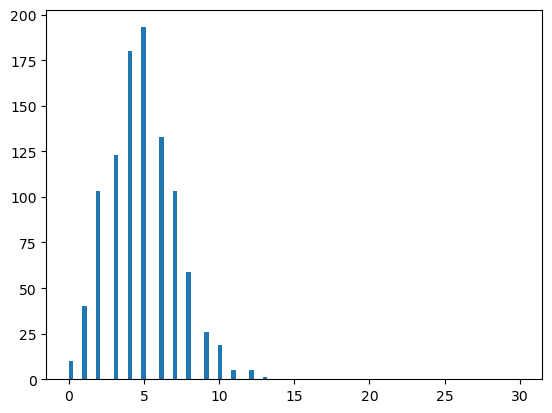

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm

# Generate random data
data = np.random.poisson(lam=5, size=1000)

# Create histogram
hist, bins, _ = plt.hist(data, bins=100, range=(0, 30))

# Define Landau function
# def landau(x, amp, mu, sigma):
#     return amp * skewnorm.pdf(x, a=-1, loc=mu, scale=sigma)

# def landau(x, A, mu, sigma):
#     # if (x - mu) / sigma < -5.: return 0.
#     return A * np.exp(- (x - mu) / sigma) * np.sinh((x - mu) / sigma)
hist
# bins

In [22]:
# Define the Landau function
def landau(x, mu, sigma):
    # Note that the Landau function is not symmetric, so it's not a Gaussian
    # It's defined using the CERN ROOT library's implementation
    # https://root.cern.ch/doc/v608/Landau_8cxx_source.html
    u = (x - mu) / sigma
    # if u < -5.:
    #     return 0.
    v = np.exp(-np.exp(-u) - u)
    return v / sigma

# Fit Landau function to histogram
from scipy.optimize import curve_fit
popt, pcov = curve_fit(landau, bins, hist)



ValueError: operands could not be broadcast together with shapes (101,) (100,) 

In [21]:
def landau(x, a, b):
    # Note that the Landau function is not symmetric, so it's not a Gaussian
    # It's defined using the CERN ROOT library's implementation
    # https://root.cern.ch/doc/v608/Landau_8cxx_source.html
    u = (x - a) / b
    # if u < -5.:
    #     return 0.
    v = np.exp(-np.exp(-u) - u)
    return v / b

def func(x, a, b,c):
    return a*np.sqrt(x)*(b*np.square(x)+c)

x = [20,30,40,50,60,70]

x = np.array(x)

num = [453,482,503,508,498,479]

y = np.array(num)

#非线性最小二乘法拟合

popt, pcov = curve_fit(landau, x, y)

print(popt)

[1. 1.]


/gwdata/users/lzhang/public/miniconda3/envs/my_root_env/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [ ]:
# Plot histogram with fitted curve
x = np.linspace(0, 30, 1000)
plt.plot(x, landau(x, *popt), 'r-', label='fit')
plt.legend()
plt.show()

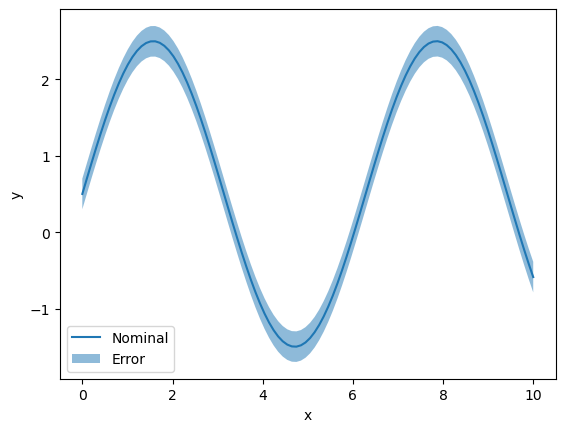

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function with multiple parameters
def func(x, a, b, c):
    return a*np.sin(b*x) + c

# Define the parameter values and uncertainties
a = 2.0
b = 1.0
c = 0.5
a_err = 0.1
b_err = 0.2
c_err = 0.2

# Define the range of x values
x = np.linspace(0, 10, 100)

# Calculate the function values at the nominal parameter values and at +/- 1 sigma for each parameter
y_nominal = func(x, a, b, c)
# y_upper = func(x, a+a_err, b+b_err, c+c_err)
y_upper = func(x, a, b, c+c_err)
# y_lower = func(x, a-a_err, b-b_err, c-c_err)
y_lower = func(x, a, b, c-c_err)

# Plot the function curve with a shaded band representing the error
plt.plot(x, y_nominal, label='Nominal')
plt.fill_between(x, y_upper, y_lower, alpha=0.5, label='Error')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()
